# Beta-Variational Autoencoder

The Beta-VAE is an intuitively simple extension on the typical VAE that enhances the "disentanglement" of the latent space by placing greater importance on the KL divergence term in the loss function using the parameter beta.


## Pytorch Implementation

Using pytorch and the mnist dataset.

Import everything:

In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader,Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda
import torchvision.models as models
import time
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

Lets use weights and bisases. You will need an account.
If running this on a cluster with jupyter nbconvert then you will have to add your wandb key as a environment variable in the container.

In [2]:
import wandb

Edit the below cell to setup project global variables

In [3]:
#Variables
batch_size = 32
learning_rate = 1e-4
epochs = 18
input_size = 28*28
latent_size = 2
hidden_size = 512
model_name = "model_z2_1.pth"
weights_name = "model_weights_z2_1.pth"

wandb.init(project="Beta-VAE-MNIST",
           config={
               "batch_size": batch_size,
               "learning_rate": learning_rate,
               "dataset": "MNIST",
           })

#Beta specific parameters
Beta = 4 #the value for beta used for the experiments in the paper.



# Get cpu or gpu device for training.
# device = "cpu"
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

wandb: Currently logged in as: jcoll44 (use `wandb login --relogin` to force relogin)


Using cuda device


Now, let's set up our MNIST dataset. This is a simple setup and uses built in functions that can be found almost line-for-line in the pytorch quickstart guide

In [4]:
training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)


train_dataloader = DataLoader(training_data, batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size)

#Printing data
for X, y in test_dataloader:
    print("Shape of X [N, C, H, W]: ", X.shape)
    print("Shape of y: ", y.shape, y.dtype)
    break

Shape of X [N, C, H, W]:  torch.Size([32, 1, 28, 28])
Shape of y:  torch.Size([32]) torch.int64


Now to create a class for the encoder and decoder.

In [5]:
class EncoderNeuralNetwork(nn.Module):
    def __init__(self,input_size, hidden_size):
        super().__init__()
        self.network = torch.nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
        )
        
    def forward(self, x):
        return self.network(x)
    
class DecoderNeuralNetwork(nn.Module):
    def __init__(self,input_size, hidden_size, output_size):
        super().__init__()
        self.network = torch.nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, output_size),      
        )
        
    def forward(self, x):
        return self.network(x)

Now to instantiate our encoder and decoder classes to create a variational autoencoder.
Up until here it is pretty easy to follow. This next bit is where the magic happens.
Look for the *Beta line in the forward() method.

In [6]:
class VAE(nn.Module):
    def __init__(self, input_size, hidden_size, latent_size):
        super().__init__()
        self.encoder = EncoderNeuralNetwork(input_size, hidden_size)
        self.decoder = DecoderNeuralNetwork(latent_size, hidden_size, input_size)
        
        # Parameters for decoding the output of the encoder
        self.fc_mu = nn.Linear(hidden_size, latent_size) #mu is the mean
        self.fc_var = nn.Linear(hidden_size, latent_size) #var is the variance
        
        # for the gaussian likelihood
        self.log_scale = nn.Parameter(torch.Tensor([0.0]))

    def gaussian_likelihood(self, x_hat, logscale, x):
        scale = torch.exp(logscale)
        mean = x_hat
        dist = torch.distributions.Normal(mean, scale)

        # measure prob of seeing image under p(x|z)
        log_pxz = dist.log_prob(x)
        return log_pxz.sum(-1)

    def kl_divergence(self, z, mu, std):
        # --------------------------
        # Monte carlo KL divergence
        # --------------------------
        # 1. define the first two probabilities (in this case Normal for both)
        p = torch.distributions.Normal(torch.zeros_like(mu), torch.ones_like(std))
        q = torch.distributions.Normal(mu, std)

        # 2. get the probabilities from the equation
        log_qzx = q.log_prob(z)
        log_pz = p.log_prob(z)

        # kl
        kl = (log_qzx - log_pz)
        kl = kl.sum(-1)
        return kl 
    
    def encode(self, x):
        #Encoder otherwise known as q. Pass x through it.
        encoded_x = self.encoder(x)
        
        #Use the encoding to find the mean and variance
        mu, log_var = self.fc_mu(encoded_x), self.fc_var(encoded_x)
        
        # sample z from q
        std = torch.exp(log_var / 2)
        q = torch.distributions.Normal(mu, std)
        z = q.rsample()
        
        return z, mu, std
    
    def decode(self, z):
        return self.decoder(z)
        
    def forward(self, x):

        #Encode x to find z
        z, mu, std = self.encode(x)
        
        # decode the latent space, otherwise known as the function p.
        # x_hat because this is the new x
        x_hat = self.decode(z)
        
        # Calculate the ELBO loss. Remember the two parts....1 Reconstruction Loss and 2 KL divergence
        # 1 reconstruction loss
        recon_loss = self.gaussian_likelihood(x_hat, self.log_scale, x)
        recon_loss = recon_loss*-1
        
        # 2 KL divergence
        # In this notebook we are replicating beta VAE
        kl = self.kl_divergence(z, mu, std)*Beta
        
        #Evidence lower bound
        elbo = recon_loss + kl
        elbo = elbo.mean()
        
        return elbo, recon_loss.mean(), kl.mean(),  x_hat, z
    


Now that we have the VAE class we can go about setting up training and testing functions.

In [7]:
model = VAE(input_size = input_size, hidden_size = hidden_size, latent_size = latent_size).to(device)
print(model)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

def train(dataloader, model, optimizer):
    size = len(dataloader.dataset)
    model.train()
    model.zero_grad()
    for (image, _) in dataloader:
    # for batch, (X, y) in enumerate(dataloader):
    
        # Compute prediction and loss
        image = image.reshape(-1, 28*28)
        image = image.to(device)
        # X, y = X.to(device), y.to(device)
        optimizer.zero_grad()

        elbo, recon_loss, kl,  x_hat, z = model(image)
        loss = elbo

        # Backpropagation
        loss.backward()
        optimizer.step()
        
def test(dataloader, model):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss= 0
    kl_loss= 0
    recon_loss= 0

    with torch.no_grad():
        for X, y in dataloader:
            image = X.reshape(-1, 28*28)
            image = image.to(device)
            elbo, recon, kl, x_hat, z = model(image)
            test_loss += elbo
            kl_loss += kl
            recon_loss += recon
            
    
    test_loss_avg = test_loss/num_batches
    kl_loss /= num_batches
    recon_loss /= num_batches
    wandb.log({"loss": test_loss_avg, 
               "elbo": test_loss, 
               "kl": kl_loss,
               "reconstruction": recon_loss
              })
    wandb.watch(model)
    return test_loss_avg
    

VAE(
  (encoder): EncoderNeuralNetwork(
    (network): Sequential(
      (0): Linear(in_features=784, out_features=512, bias=True)
      (1): ReLU()
      (2): Linear(in_features=512, out_features=512, bias=True)
      (3): ReLU()
    )
  )
  (decoder): DecoderNeuralNetwork(
    (network): Sequential(
      (0): Linear(in_features=2, out_features=512, bias=True)
      (1): ReLU()
      (2): Linear(in_features=512, out_features=512, bias=True)
      (3): ReLU()
      (4): Linear(in_features=512, out_features=784, bias=True)
    )
  )
  (fc_mu): Linear(in_features=512, out_features=2, bias=True)
  (fc_var): Linear(in_features=512, out_features=2, bias=True)
)


Train our model and use the test dataset to plot the loss and other significant values.

In [8]:
%%wandb

#Timing the hardware difference
tic = time.perf_counter()

for t in range(epochs):
    train(train_dataloader, model, optimizer)
    test_loss = test(test_dataloader, model)
    if t%20==0:
        print(f"Epoch {t+1}\n-------------------------------")    
        print(f"Avg loss: {test_loss:>8f} \n")
print("Done!")

toc = time.perf_counter()
if {device} == "cpu":
    print(f"CPU time {toc - tic:0.4f} seconds")
else:
    print(f"GPU time {toc - tic:0.4f} seconds")

Epoch 1
-------------------------------
Avg loss: 612.701294 

Done!
GPU time 190.9489 seconds


Now that we have trained our model we should save the model and the model weights.

In [9]:
torch.save(model, model_name)
torch.save(model.state_dict(), weights_name)

## Plotting and Visualisation

Lets begin our visualisation by plotting some randomly chosen numbers before reconstruction and after reconstruction.

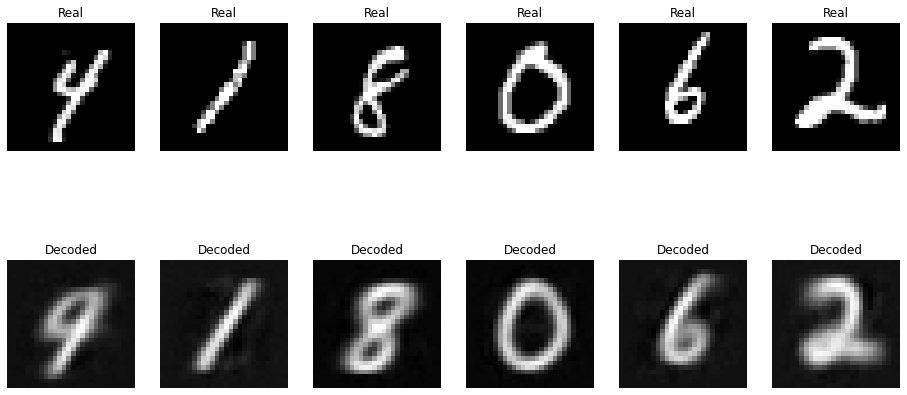

In [10]:
figure = plt.figure(figsize=(16, 8))
cols, rows = 6, 2
for i in range(1, cols +1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    image = img.reshape(-1, 28*28)
    image = image.to(device)
    elbo, recon, kl, x_hat, z = model(image)
    pred = x_hat.to("cpu")
    pred = pred.detach().numpy()
    figure.add_subplot(rows, cols, i)
    plt.title("Real")
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
    figure.add_subplot(rows, cols, i+cols)
    plt.title("Decoded")
    plt.axis("off")
    plt.imshow(pred.reshape(1,28,28).transpose(1, 2, 0), cmap="gray")
plt.show()

Now lets investigate the latent space further. The plot below shows the latent space and where different MNIST numbers are located within it. They should be clustered by their number and centrally located around 0 as we directed them to be.

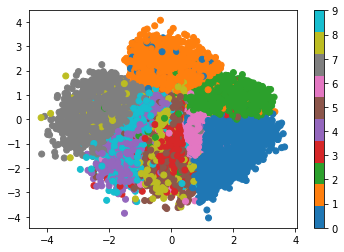

In [22]:
def plot_latent(model, dataloader, num_batches=100):
    for (image, y) in dataloader:
        image = image.reshape(-1, 28*28)
        image = image.to(device)
        elbo, recon, kl, x_hat, z = model(image)
        z = z.to('cpu').detach().numpy()
        plt.scatter(z[:, 0], z[:, 1], c=y, cmap='tab10')

    plt.colorbar()
            
plot_latent(model, train_dataloader)

Now lets do a linear interpolation between all the number, i.e. 1->2, 2->3 etc.
We can do this by taking the latent space of 2 numbers (e.g. 1 and 2) and calculating the latent vector halfway between them.

In [ ]:
number_array = []
figure = plt.figure(figsize=(25, 12))
cols, rows = 10 , 3

for k in range(10):
    for (image, y) in training_data:
        if y==k:
            number_array.append(image)
            break
    
for l in range(1,10):
    number_a = number_array[l-1].reshape(-1, 28*28)
    number_a = number_a.to(device)
    elbo, recon, kl, x_hat_a, z_a = model(number_a)
    
    number_b = number_array[l].reshape(-1, 28*28)
    number_b = number_b.to(device)
    elbo, recon, kl, x_hat_b, z_b = model(number_b)
    
    figure.add_subplot(rows, cols, l)
    plt.title(str(l-1))
    plt.axis("off")
    plt.imshow(x_hat_a.to("cpu").detach().numpy().reshape(1,28,28).transpose(1, 2, 0), cmap="gray")
    
    figure.add_subplot(rows, cols, l+(cols*2))
    plt.title(str(l))
    plt.axis("off")
    plt.imshow(x_hat_b.to("cpu").detach().numpy().reshape(1,28,28).transpose(1, 2, 0), cmap="gray")
    
    z_c = z_a*0.5 + z_b*0.5
    number_c = z_c.to(device)
    x_hat = model.decode(number_c)
    figure.add_subplot(rows, cols, l+(cols))
    plt.title(str(l-1)+" merged with "+str(l))
    plt.axis("off")
    plt.imshow(x_hat.to("cpu").detach().numpy().reshape(1,28,28).transpose(1, 2, 0), cmap="gray")
    
plt.show()

For our last visualisation lets produce a square "walk" around the latent space. This is similar to the plot_latent() function above although with images rather than a scatter plot.

In [ ]:
def plot_reconstructed(autoencoder, r0=(-6, 5), r1=(-6, 5), n=12):
    w = 28
    img = np.zeros((n*w, n*w))
    for i, y in enumerate(np.linspace(*r1, n)):
        for j, x in enumerate(np.linspace(*r0, n)):
            z = torch.Tensor([[x, y]]).to(device)
            x_hat = autoencoder.decoder(z)
            x_hat = x_hat.reshape(28, 28).to('cpu').detach().numpy()
            img[(n-1-i)*w:(n-1-i+1)*w, j*w:(j+1)*w] = x_hat
    plt.imshow(img, extent=[*r0, *r1], cmap="gray")
    
plot_reconstructed(model2, (-6, 5), (-6, 5), 12)

If we wanted to reload the model at a latter date we could do so with the code below. Just make sure to run the classes up above first.

In [21]:
# Model class must be defined somewhere
model = torch.load(model_name)
model.load_state_dict(torch.load(weights_name))
model.eval()

VAE(
  (encoder): EncoderNeuralNetwork(
    (network): Sequential(
      (0): Linear(in_features=784, out_features=512, bias=True)
      (1): ReLU()
      (2): Linear(in_features=512, out_features=512, bias=True)
      (3): ReLU()
    )
  )
  (decoder): DecoderNeuralNetwork(
    (network): Sequential(
      (0): Linear(in_features=2, out_features=512, bias=True)
      (1): ReLU()
      (2): Linear(in_features=512, out_features=512, bias=True)
      (3): ReLU()
      (4): Linear(in_features=512, out_features=784, bias=True)
    )
  )
  (fc_mu): Linear(in_features=512, out_features=2, bias=True)
  (fc_var): Linear(in_features=512, out_features=2, bias=True)
)